<a href="https://colab.research.google.com/github/AishwaryaKalloli/andrejk/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install micrograd

In [ ]:
from micrograd.engine import Value

In [ ]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += 1
c = 1 + c - a
print(f"a: {a}, b: {b}, c: {c}, d: {d}")
d += d * 2 + (b + a).relu()
print(f"a: {a}, b: {b}, c: {c}, d: {d}")
d += 3 * d + (b - a).relu()
print(f"a: {a}, b: {b}, c: {c}, d: {d}")
e = c - d
f = e ** 2
g = 10.0 / f
print(f"a: {a}, b: {b}, c: {c}, d: {d}, e: {e}, f: {f}, g: {g}")
print(f"a: {a.grad:.4f}, b: {b.grad:.4f}, c: {c.grad:.4f}, d: {d.grad:.4f}, e: {e.grad:.4f}, f: {f.grad:.4f}, g: {g.grad:.4f}")
g.backward()
print(f"a: {a}, b: {b}, c: {c}, d: {d}, e: {e}, f: {f}, g: {g}")
print(f"a: {a.grad:.4f}, b: {b.grad:.4f}, c: {c.grad:.4f}, d: {d.grad:.4f}, e: {e.grad:.4f}, f: {f.grad:.4f}, g: {g.grad:.4f}")

a: Value(data=-4.0, grad=0), b: Value(data=2.0, grad=0), c: Value(data=4.0, grad=0), d: Value(data=0.0, grad=0)
a: Value(data=-4.0, grad=0), b: Value(data=2.0, grad=0), c: Value(data=4.0, grad=0), d: Value(data=0.0, grad=0)
a: Value(data=-4.0, grad=0), b: Value(data=2.0, grad=0), c: Value(data=4.0, grad=0), d: Value(data=6.0, grad=0)
a: Value(data=-4.0, grad=0), b: Value(data=2.0, grad=0), c: Value(data=4.0, grad=0), d: Value(data=6.0, grad=0), e: Value(data=-2.0, grad=0), f: Value(data=4.0, grad=0), g: Value(data=2.5, grad=0)
a: 0.0000, b: 0.0000, c: 0.0000, d: 0.0000, e: 0.0000, f: 0.0000, g: 0.0000
a: Value(data=-4.0, grad=-57.5), b: Value(data=2.0, grad=-240.0), c: Value(data=4.0, grad=2.5), d: Value(data=6.0, grad=-2.5), e: Value(data=-2.0, grad=2.5), f: Value(data=4.0, grad=-0.625), g: Value(data=2.5, grad=1)
a: -57.5000, b: -240.0000, c: 2.5000, d: -2.5000, e: 2.5000, f: -0.6250, g: 1.0000


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [ ]:
f(3.0)

20.0

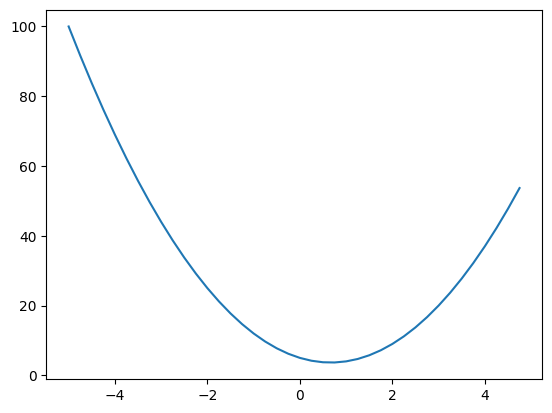

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

# derivative w.r.t to a
d1 = a * b + c
c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def __rtruediv__(self, other):
        return other * self ** -1


    def backward(self):
        # O(n) time and space complexity for figuring out topo
        # + O(n) for backward propagation, total is still linear time
        visited = set()
        topo = []
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a  = Value(2.0)
b = Value(4.0)
2 / a

Value(data=1.0, label=)

In [ ]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    # print(f"nodes: {nodes}, edges: {edges}")
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,  label = "{ %s | data %.4f | grad %.4f  }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195423, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

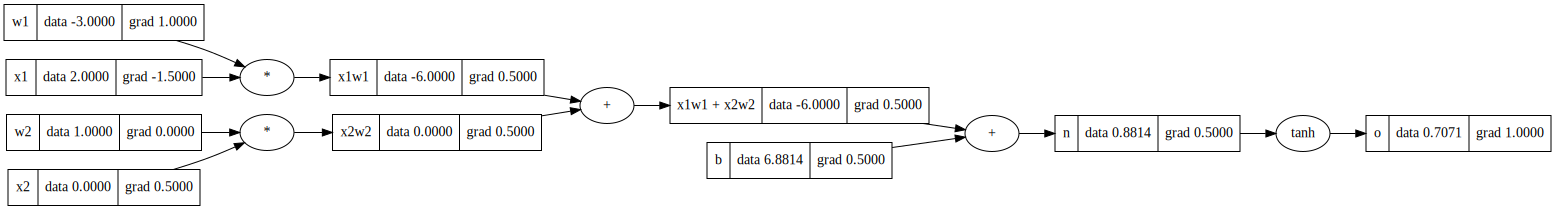

In [ ]:
draw_dot(o)

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195423, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

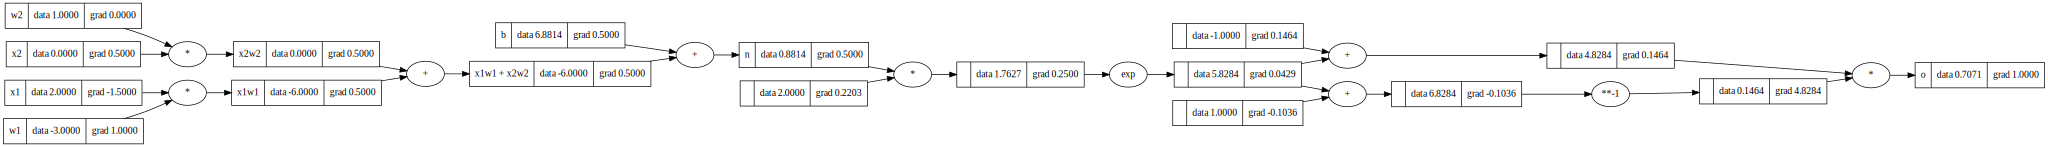

In [ ]:
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
# draw_dot(n(x))

In [ ]:
mlp = MLP(3, [4, 4, 1])

In [ ]:
len(mlp.parameters())

41

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
len(mlp.parameters())

41

In [ ]:
min_loss = float("inf")
min_loss_parameters = []
for k in range(500):
    ypred = [mlp(x) for x in xs]
    loss = sum([(ygt - yout) ** 2 for ygt, yout in zip(ys, ypred)])
    # if loss.data < min_loss:
        # min_loss = loss.data
        # min_loss_parameters = mlp.parameters().copy()
        # print("checkpoint saved")

    # set all grads to 0 so that we recalculate them later
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    for p in mlp.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)


0 0.00013356427133444644
1 0.00013347285622570285
2 0.00013338156429353414
3 0.00013329039529059663
4 0.00013319934897022836
5 0.00013310842508640743
6 0.00013301762339377
7 0.0001329269436476129
8 0.00013283638560388354
9 0.00013274594901916163
10 0.0001326556336506945
11 0.0001325654392563649
12 0.00013247536559469336
13 0.00013238541242484666
14 0.0001322955795066282
15 0.0001322058666004783
16 0.00013211627346747007
17 0.00013202679986930782
18 0.00013193744556832724
19 0.000131848210327491
20 0.00013175909391038593
21 0.0001316700960812199
22 0.00013158121660483018
23 0.00013149245524666782
24 0.00013140381177280654
25 0.00013131528594992423
26 0.00013122687754532235
27 0.0001311385863269096
28 0.00013105041206320833
29 0.0001309623545233392
30 0.00013087441347703864
31 0.00013078658869463853
32 0.00013069887994707666
33 0.00013061128700588533
34 0.00013052380964320373
35 0.0001304364476317549
36 0.0001303492007448651
37 0.00013026206875644685
38 0.00013017505144100115
39 0.000130

In [ ]:
min_loss_parameters != mlp.parameters()

True